<a href="https://colab.research.google.com/github/jyanqa/Narative-Economy/blob/main/Monthly_Data_Macro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

## 1 Data

In [ ]:
url = 'https://drive.google.com/uc?id=' +  '1VXuxMfSYwZY80SlB7e1HfPshvwo72l2T'

In [ ]:
df = pd.read_csv(url, sep = '|')
#pd.set_option('display.max_colwidth',None)
#pd.set_option('display.max_colwidth',-1)
#pd.set_option('display.width', 5)

### Subset

In [ ]:
# speech in 2021
d21 = df[(df['date'] > '2018-01-01') & (df['date'] < '2021-5-31')]
#drop empty row
d21 = d21.dropna(how ='any')
#dataframe | remain only two colums
d21 = d21[['date','contents']]

#### Merge text groupby month

In [ ]:
d21['date'] = pd.to_datetime(d21['date']) #convert columns date to datetime
d21["day"] = d21['date'].map(lambda x: x.day) #extract a day column
d21["month"] = d21['date'].map(lambda x: x.month) #extract a month column
d21["year"] = d21['date'].map(lambda x: x.year) #extract a year column

In [ ]:
#groupby speech in the same month and year
d21['speeches'] = d21.groupby(['month','year'])['contents'].transform(lambda x: ','.join(x)) 
df21 = d21[['year','month','speeches']].drop_duplicates()

from datetime import date #merge column year and month to yymm
df21['yymm'] = pd.to_datetime(df21[['year', 'month']].assign(DAY=1))
df21 = df21[['yymm', 'speeches']]

In [ ]:
df21= df21.reset_index(drop = True)
#df21.head(5) #df21.shape[0]

#### Split into sentences

In [ ]:
a = df21
cols_name = ['yymm', 'sent']
df_sent = pd.DataFrame(columns=cols_name)
for i in range(a.shape[0]):
    yymm = a.iloc[i][0]
    text = a.iloc[i][1]
    sent_temp = text.split('.')
    df_temp = pd.DataFrame(columns=cols_name)
    for t in sent_temp:
        arr = [yymm,t] #value of a ro
        df_length = len(df_sent) #
        df_sent.loc[df_length] = arr 

In [ ]:
df_sent

,yymm,sent
0,2021-05-01,SPEECH Societal responsibility and central...
1,2021-05-01,"New Paradigm Workshop”, organised by the Foru..."
2,2021-05-01,Chart 1 Consumer price inflation (1960-1990...
3,2021-05-01,The delegation of the task of maintaining ...
4,2021-05-01,This underpins the large degree of political ...
...,...,...
46833,2018-01-01,The stock of long-duration assets held in our...
46834,2018-01-01,Policy rates remaining at their present level...
46835,2018-01-01,[1] I would like to thank F
46836,2018-01-01,Holm-Hadulla for his support in preparing thi...


#### Assign topic to a sentence.

## 2 ECB Communication

We measure the ECB's communication by two features: Topic and Tone. That is, we determine first the economic topic of the speeches. After that, we measures how they are talking about it (tone). In this paper, we make use of Latent Dirichlet Allocation (LDA) to know when they are talking about economic topic and a balance measure based on dictionary methods, or word counting, to measure tone. By combining these two approaches allows us to measure topic-level tone which helps to deal, somewhat, with the weakness of dictionary methods. That is, rather than just measure words associated with expansion, we can measure expansion words associated with GDP growth rather than risk premia.

### Step 1: Assign topics tp a sentence 

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import string
import re
import nltk

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
  
ps = PorterStemmer()

In [ ]:
otherstop =  ['-', '%', 'g','bank', 'ecb','euro', 'also','speech','financial','-;','le','p','r','j','f','c','one',
             'e','op','-','_','left','(chart', 'likely', 'could','l','n','(question', '()','del','di', 'u','w',
                'h', 'b','k', 'q', 'v','co','listen',  'nevertheless', 'truly', 'enable', 'aml', 'somewhat', 'get', 
              'add', 'partly', 'http', 'brings', 'ed', 'known', 'became','missing',  'likelihood', 'der', 'fed', 'und', 
              'notion', 'sepa','offering', 'follows', 'offered', 'tell', 'really', 'anniversary', 'determine',
              'learning', 'ask', 'hearing', 'bringing', 'unique', 'represent', 'seriously', 'analytical', 'ex', 
              'desired', 'meaningful', 'delivered', 'generate', 'multi', 'expressed', 'analyse', 'eur', 'round', 
              'unlike', 'relating', 'accounting', 'happened', 'bit', 'wish', 'applying', 'hour', 'weigh', 'managing', 
              'von', 'resolve', 'likewise', 'culture', 'compare', 'usually', 'favour', 'otc', 'nairu', 'portugal', 
              'coin', 'live', 'vi', 'pronounced', 'lehman', 'branch', 'underpin', 'maintained', 'ab', 'youth', 'human', 
              'page', 'indicate', 'capture', 'official', 'represented', 'greek', 'stop', 'worked', 'repos', 'focusing', 
              'dialogue', 'discussing', 'reported', 'concluded', 'cepr', 'prior', 'fcis', 'italy','spain','germany',
              'netherland','x','netherlands','italian','die','feel','fifth','elswhere','person','slightly', 'omt', 
              'traditionally','french', 'entirely','assessed','orderly','sharply','wall','latter','woman','st','talk',
              'fairly','forget','bearing','preventing','altavilla','exception','collective', 'recorded', 'steadily',
              'tail','supportive','spanish','workshop','domain','acted','nonetheless','focused','noted','opening',
              'attractive','sample','frequently','eye','suggested','coefficient','ois','learn','gone','recieved',
              'luxembourg','slovakia','involve','obtain','contact','correct','wind','washington','posed','subsequent',
              'check','comment','solely','received', 'chapter','huge','exceptional','obvious', 'versus', 'fast',
              'naturally','entitled','prove','embedded','corresponding','berlin','committed',
              'careful','material','lose','agree','explanation','da','rapidly','continent','greatly',
              'chicago','background','explaining','involving','entered','arising', 'versus','comply',
              'extremely', 'intra', 'neither', 'york', 'japan', 'soon', 'professional', 'none', 'pdf',
              'borne', 'unlikely', 'gained', 'perhaps', 'tomorrow', 'came', 'lie', 'easily', 'ncio', 'met', 'concerned', 
              'seem', 'en', 'decide', 'intended', 'speaking', 'excluding', 'meaning', 'gave', 'prepared', 'refers',
              'wrong', 'begin', 'everyone', 'implied', 'presented', 'refer']
stop= stopwords.words('english')
stop.extend(list(string.punctuation))
stop.extend(otherstop)
lemma=WordNetLemmatizer()
def clean(docx):
    doc = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(docx))
    doc1 = re.sub(r'\d+', '', doc)
    stop_free=" ".join([i for i in doc1.lower().split() if i not in stop])
    normalized=" ".join(lemma.lemmatize(word) for word in stop_free.split())
    #normalized1 =" ".join(ps.stem(word) for word in normalized.split())
    return normalized
####
##
text_complete = df_sent['sent'].values.tolist()
doc_clean=[clean(text).split() for text in text_complete]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

SOME_FIXED_SEED = 42
np.random.seed(SOME_FIXED_SEED)
cv=CountVectorizer(min_df=2,max_df=50,#ngram_range=(1,2),
                   token_pattern=None,
                   tokenizer=lambda doc:doc,preprocessor=lambda doc:doc, 
                   stop_words = frozenset(stop))
#'''INPUT HERE'''
cv_features=cv.fit_transform(doc_clean) 
vocabulary=np.array(cv.get_feature_names())

In [ ]:
'''Using sklearn.decomposition LDA with 15 topics'''
from sklearn.decomposition import LatentDirichletAllocation
TOTAL_TOPICS = 15
lda_model=LatentDirichletAllocation(n_components=TOTAL_TOPICS,
                                    max_iter=10,max_doc_update_iter=10,
                                    learning_method='online',batch_size=128,
                                    learning_offset=50.,random_state=42,n_jobs = -1)

'''Using the transformer 'fit_transform'''
document_topics=lda_model.fit_transform(cv_features)

''' Extraqcting the most important 10 terms for each topic'''
topic_terms=lda_model.components_
top_terms=15 # number of 'top terms'
topic_key_terms_idxs=np.argsort(-np.absolute(topic_terms), axis=1)[:,:top_terms]

'''INPUT vocabulary'''
topic_keyterms=vocabulary[topic_key_terms_idxs]
topics=[', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth',None)
topics_df=pd.DataFrame(topics,columns=['Term per Topic'], index=['Topic'+str(t) for t in range(1,TOTAL_TOPICS+1)])
topics_df



,Term per Topic
Topic1,"const, resort, harmonisation, wholesale, leaning, risen, lender, compensation, floor, fluctuation, depositor, permanent, belief, grown, reflection"
Topic2,"difficulty, standardised, successfully, equal, aftermath, decrease, concerning, strategic, fsb, reap, dealing, equivalent, mitigating, tangible, accepted"
Topic3,"psd, sensitivity, converge, shadow, virtual, deleveraging, mortgage, constant, meant, concrete, prudent, outflow, reliable, genuine, otherwise"
Topic4,"contributes, incident, anticipated, emerged, granted, fair, complementary, complexity, narrow, raised, rose, database, separate, journey, calculated"
Topic5,"buy, weight, balanced, frontier, stood, costly, recovered, aligned, store, surrounding, diffusion, characterised, break, tends, indicated"
Topic6,"diversification, continuing, fear, anchored, revolution, backdrop, enabling, acceptance, understood, trough, fragmented, planning, determining, disinflationary, feed"
Topic7,"ssm, yves, accept, simulation, author, outright, creates, safeguarding, regional, delay, amid, turned, proportionate, consistently, automation"
Topic8,"statute, triggered, employed, contained, ground, argument, boom, box, democracy, proper, prepare, emir, described, shifting, challenged"
Topic9,"application, counterparty, bear, deutsche, anchoring, pick, signalling, thinking, discipline, peak, caput, issuing, conditional, appreciation, recognition"
Topic10,"surprise, albeit, commerce, spirit, coordinated, lecture, passed, adapt, slower, volatile, inflow, carried, parameter, multiple, reversal"


#### WordCloud

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
''' Extraqcting the most important 150 terms for each topic'''
topic_terms=lda_model.components_
top_terms=150 # number of 'top terms'
topic_key_terms_idxs=np.argsort(-np.absolute(topic_terms), axis=1)[:,:top_terms]

'''INPUT vocabulary'''
topic_keyterms=vocabulary[topic_key_terms_idxs]
topics=[', '.join(topic) for topic in topic_keyterms]
#pd.set_option('display.max_colwidth',None)
topics_df=pd.DataFrame(topics,columns=['Term per Topic'], index=['Topic'+str(t) for t in range(1,TOTAL_TOPICS+1)])
topics_df
topics = topics_df.transpose()

In [ ]:
'''from google.colab import files
from io import BytesIO
from PIL import Image

uploaded = files.upload()
im = Image.open(BytesIO(uploaded['25403.png']))
euro = np.array(im)'''

"from google.colab import files\nfrom io import BytesIO\nfrom PIL import Image\n\nuploaded = files.upload()\nim = Image.open(BytesIO(uploaded['25403.png']))\neuro = np.array(im)"

In [ ]:
'''''values = ','.join(str(v) for v in topics['Topic14']) 
# A similar function, but using the mask
def generate_better_wordcloud(data, title, mask=None):
    cloud = WordCloud(scale=3,
                      max_words=150,
                      colormap='Set1',
                      mask=mask,
                      background_color='black',
                      stopwords=stop,
                      collocations=True).generate_from_text(data)
    plt.figure(figsize=(8 ,8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title)
    plt.show()
    ''
# Use the function with the rome_corpus and our mask to create word cloud     
generate_better_wordcloud(values, 'Topic 14', mask=euro)'''

"''values = ','.join(str(v) for v in topics['Topic14']) \n# A similar function, but using the mask\ndef generate_better_wordcloud(data, title, mask=None):\n    cloud = WordCloud(scale=3,\n                      max_words=150,\n                      colormap='Set1',\n                      mask=mask,\n                      background_color='black',\n                      stopwords=stop,\n                      collocations=True).generate_from_text(data)\n    plt.figure(figsize=(8 ,8))\n    plt.imshow(cloud)\n    plt.axis('off')\n    plt.title(title)\n    plt.show()\n    ''\n# Use the function with the rome_corpus and our mask to create word cloud     \ngenerate_better_wordcloud(values, 'Topic 14', mask=euro)"

### Sentimental Analysis

In [ ]:
doc_topic = lda_model.transform(cv_features)
list_topic = []
for i in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[i].argmax()
    list_topic.append(topic_most_pr)
df_sent['topic'] = list_topic
df_sent.head(2)

,yymm,sent,topic
0,2021-05-01,"SPEECH Societal responsibility and central bank independence Keynote speech by Isabel Schnabel, Member of the Executive Board of the ECB, at the “VIII",12
1,2021-05-01,"New Paradigm Workshop”, organised by the Forum New Economy Frankfurt am Main, 27 May 2021 Central banking in times of shifting societal concerns The best contribution that central banks can make to economic prosperity is to maintain stable prices: this was the broad consensus among academic scholars and policymakers emerging in the late 1970s when inflation in many advanced economies had surged to double-digit levels, thereby eroding purchasing power and hitting the poorest in society the hardest (Chart 1)",13


In [ ]:
sent1 = df_sent.loc[df_sent['topic']==1]
sent3= df_sent.loc[df_sent['topic']==3]
sent11 = df_sent.loc[df_sent['topic']==11]
sent12 = df_sent.loc[df_sent['topic']==12]
sent13 = df_sent.loc[df_sent['topic']==13]
sent14 = df_sent.loc[df_sent['topic']==14]
sent_all = sent1.append(sent3).append(sent11).append(sent12).append(sent13).append(sent14)
sent_all = sent_all.reset_index(drop = True)
df_topsent = sent_all.reset_index(drop = True)
df_topsent.head(2)
#df_topsent['sent'] = df_topsent.groupby(['yymm'])['sent'].transform(lambda x: ','.join(x.to_string(index=False)))
df_topsent.head(2) #chan ghe ko lam dc nen thu lai luc nao co thoi gian

,yymm,sent,topic
0,2021-05-01,Independent central banks cannot simply turn a deaf ear to the concerns of the public,1
1,2021-05-01,"[8] More so, independence requires a central bank to respond to the concerns of the public and to carefully evaluate whether and how it may be able, within its mandate, to respond to these concerns",1


In [ ]:
%matplotlib inline
xvals = np.arange(len(df_sent['topic'].value_counts()))
yvals = list(df_sent['topic'].value_counts())

counts, bins, _ = plt.hist(df_sent['topic'],color = 'darkred')

for n, b in zip(counts, bins):
        plt.gca().text(b + 0.1, n, str(n))
plt.ylabel('Number of sentences')
plt.xlabel('Topic')
plt.show()

NameError: ignored

In [ ]:
%matplotlib inline
xvals = np.arange(len(df_topsent['topic'].value_counts()))
yvals = list(df_topsent['topic'].value_counts())

counts, bins, _ = plt.hist(df_topsent['topic'], color = 'darkred')

for n, b in zip(counts, bins):
        plt.gca().text(b + 0.1, n, str(n))
plt.ylabel('Number of sentences')
plt.xlabel('Topic')
plt.show()

NameError: ignored

In [ ]:
#print(df_topsent.shape) #dataframe from 46k to 13k

In [ ]:
df_ts = df_topsent[ df_topsent['sent'].astype(str) == df_topsent['sent']]
print(df_ts.shape)

(13508, 3)


In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 35.5MB/s 


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
'''''# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    analyzer = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = analyzer.polarity_scores(sentence)
     
    print("Overall sentiment dictionary is : ", sentiment_dict)
    print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
    print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
    print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
 
    print("Sentence Overall Rated As", end = " ")
      # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        print("Positive")
 
    elif sentiment_dict['compound'] <= - 0.05 :
        print("Negative")
 
    else :''
        print("Neutral")'''
 
  
 

'\'\'# function to print sentiments\n# of the sentence.\ndef sentiment_scores(sentence):\n \n    # Create a SentimentIntensityAnalyzer object.\n    analyzer = SentimentIntensityAnalyzer()\n \n    # polarity_scores method of SentimentIntensityAnalyzer\n    # object gives a sentiment dictionary.\n    # which contains pos, neg, neu, and compound scores.\n    sentiment_dict = analyzer.polarity_scores(sentence)\n     \n    print("Overall sentiment dictionary is : ", sentiment_dict)\n    print("sentence was rated as ", sentiment_dict[\'neg\']*100, "% Negative")\n    print("sentence was rated as ", sentiment_dict[\'neu\']*100, "% Neutral")\n    print("sentence was rated as ", sentiment_dict[\'pos\']*100, "% Positive")\n \n    print("Sentence Overall Rated As", end = " ")\n      # decide sentiment as positive, negative and neutral\n    if sentiment_dict[\'compound\'] >= 0.05 :\n        print("Positive")\n \n    elif sentiment_dict[\'compound\'] <= - 0.05 :\n        print("Negative")\n \n    el

In [ ]:
df_ts.iloc[1140:1141,:] #NEGATIVE SENTENCE

,yymm,sent,topic
1140,2019-07-01,"To a significant extent, this sequence of low inflation rates reflects the prolonged adjustment dynamics that characterise the aftermath of a major global financial crisis, together with a substantial downward shift in the realisation of shocks to inflation that we have observed in recent years",1


In [ ]:
analyzer = SentimentIntensityAnalyzer()
df_ts['neg'] = df_ts['sent'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
df_ts['neu'] = df_ts['sent'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
df_ts['pos'] = df_ts['sent'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
df_ts['compound'] = df_ts['sent'].apply(lambda x:analyzer.polarity_scores(x)['compound'])
df_ts.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,yymm,sent,topic,neg,neu,pos,compound
0,2021-05-01,Independent central banks cannot simply turn a deaf ear to the concerns of the public,1,0.0,1.000,0.000,0.000
1,2021-05-01,"[8] More so, independence requires a central bank to respond to the concerns of the public and to carefully evaluate whether and how it may be able, within its mandate, to respond to these concerns",1,0.0,0.958,0.042,0.128
2,2021-05-01,"Independent central banks have a duty to respond to the concerns of the public and to carefully evaluate whether and how they may be able, within their mandate, to respond to these concerns",1,0.0,0.955,0.045,0.128


### Exercises: Create sentimental by month and topics

In [ ]:
df_ts.groupby(['yymm','topic'])['compound'].agg('sum')


yymm        topic
2018-01-01  1        2.3655
            3        6.4080
            11       1.5225
            12       2.5229
            13      -1.2991
                      ...  
2021-05-01  3        5.1469
            11       0.9669
            12       2.4416
            13       3.6310
            14       0.1894
Name: compound, Length: 243, dtype: float64

### Time Series sentimental by month, groupby compound

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker

In [ ]:
posm = df_ts.groupby(['yymm'])['pos'].agg('sum') 
negm = df_ts.groupby(['yymm'])['neg'].agg('sum')
neum = df_ts.groupby(['yymm'])['neu'].agg('sum')
compoundm = df_ts.groupby(['yymm'])['compound'].agg('sum')
ts_sent = pd.DataFrame({'pos':posm, 'neg':negm,'neu': neum,'compound': compoundm})
ts_sent.head(3)

,pos,neg,neu,compound
yymm,,,,
2018-01-01,10.584,7.567,131.854,12.8740
2018-02-01,53.648,22.588,468.762,92.5362
2018-03-01,32.075,23.194,323.733,17.6964


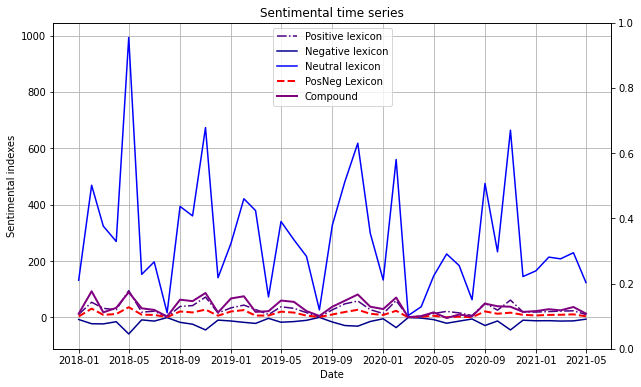

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
axb = ax.twinx()

# Same as above
ax.set_xlabel('Date')
ax.set_ylabel('Sentimental indexes')
ax.set_title('Sentimental time series')
ax.grid(True)

ax.plot(ts_sent['yymm'], ts_sent['pos'], color='indigo', label='Positive lexicon ',linestyle = '-.',linewidth=1.5)
ax.plot(ts_sent['yymm'], -ts_sent['neg'], color='darkblue', label='Negative lexicon',linestyle = '-', linewidth=1.5)
ax.plot(ts_sent['yymm'], ts_sent['neu'], color='blue', label='Neutral lexicon', linewidth=1.5)
ax.plot(ts_sent['yymm'], ts_sent['posneg'], color='red', label='PosNeg Lexicon',linestyle = '--',linewidth = 2.0)
ax.plot(ts_sent['yymm'], ts_sent['compound'] , color='purple', label='Compound',linewidth = 2.0)

# Merging legend
lines, labels = ax.get_legend_handles_labels()
#lines2, labels2 = axb.get_legend_handles_labels()
axb.legend(lines, labels, loc='upper center');

#plt.savefig('nameofp.png')

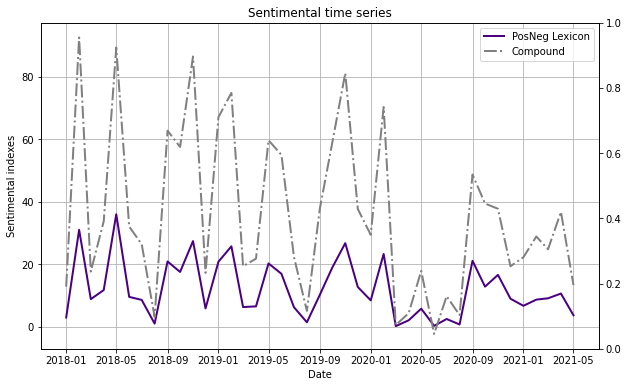

In [ ]:
ts_sent['posneg']=ts_sent['pos'] - ts_sent['neg']

fig, ax = plt.subplots(figsize=(10, 6))
axb = ax.twinx()
# Same as above
ax.set_xlabel('Date')
ax.set_ylabel('Sentimental indexes')
ax.set_title('Sentimental time series')
ax.grid(True)

ax.plot(ts_sent['yymm'], ts_sent['posneg'], color='indigo', label='PosNeg Lexicon',linewidth = 2.0)
ax.plot(ts_sent['yymm'], ts_sent['compound'] , color='grey',linestyle = '-.', label='Compound',linewidth = 2.0)

#legend
lines, labels = ax.get_legend_handles_labels()
axb.legend(lines, labels, loc='upper right');


In [ ]:
ts_sent.shape

(41, 5)

### Save data to drive

In [ ]:
'''from google.colab import drive
drive.mount('drive')
ts_sent.to_csv('ts_sent.csv')
!cp ts_sent.csv "drive/My Drive/"'''

'from google.colab import drive\ndrive.mount(\'drive\')\nts_sent.to_csv(\'ts_sent.csv\')\n!cp ts_sent.csv "drive/My Drive/"'

In [ ]:
from google.colab import files
ts_sent.to_csv('ts_sent.csv') 
files.download("ts_sent.csv")
%timeit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Yield Curves

In [ ]:
ts_sent.head(2)

,pos,neg,neu,compound
yymm,,,,
2018-01-01,10.584,7.567,131.854,12.8740
2018-02-01,53.648,22.588,468.762,92.5362


In [ ]:
x = len(ts_sent)
num_index = range(0,x,1)
ts_sent =  ts_sent.reset_index()
ts_sent

,yymm,pos,neg,neu,compound
0,2018-01-01,10.584,7.567,131.854,12.8740
1,2018-02-01,53.648,22.588,468.762,92.5362
2,2018-03-01,32.075,23.194,323.733,17.6964
3,2018-04-01,27.209,15.416,269.374,33.7946
4,2018-05-01,94.950,58.930,993.108,89.3245
5,2018-06-01,18.535,8.929,152.533,32.0886
6,2018-07-01,21.879,13.237,196.887,26.4320
7,2018-08-01,1.898,0.845,16.257,3.2082
8,2018-09-01,38.631,17.698,393.670,62.7495
9,2018-10-01,41.769,24.196,360.034,57.5397


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving yield.csv to yield.csv


In [ ]:
yie = pd.read_csv('yield.csv', sep = ';')
yie.head(2)

,Date,3m,1y,2y,5y,10y
0,2021-05,-0.631647,-0.679869,-0.674774,-0.542524,-0.146415
1,2021-04,-0.627818,-0.683253,-0.699461,-0.567790,-0.179994


In [ ]:
yie = yie[['3m','1y','2y','5y','10y']]

In [ ]:
yie0 = yie.sort_index(axis=0, ascending=False)
yie0 = yie0.reset_index(drop=True)
yie0.head(2)

,3m,1y,2y,5y,10y
0,-0.625430,-0.639447,-0.205301,0.046598,0.709876
1,-0.655109,-0.681066,-0.257543,0.011679,0.709144


In [ ]:
type(yie.iloc[0,1])

numpy.float64

## OLS

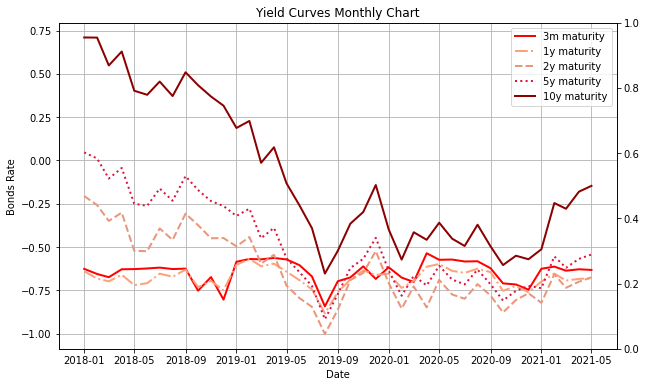

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
axb = ax.twinx()
# Same as above
ax.set_xlabel('Date')
ax.set_ylabel('Bonds Rate')
ax.set_title('Yield Curves Monthly Chart')
ax.grid(True)

ax.plot(ts_sent['yymm'], yie0['3m'], color='red', label='3m maturity',linewidth = 2.0)
ax.plot(ts_sent['yymm'], yie0['1y'] , color='lightSalmon',linestyle = '-.', label='1y maturity',linewidth = 2.0)
ax.plot(ts_sent['yymm'], yie0['2y'] , color='DarkSalmon',linestyle = '--', label='2y maturity',linewidth = 2.0)
ax.plot(ts_sent['yymm'], yie0['5y'] , color='Crimson',linestyle = ':', label='5y maturity',linewidth = 2.0)
ax.plot(ts_sent['yymm'], yie0['10y'] , color='darkred',linestyle = '-', label='10y maturity',linewidth = 2.0)

#legend
lines, labels = ax.get_legend_handles_labels()
axb.legend(lines, labels, loc='upper right');

In [ ]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
x = ts_sent[['pos','neg','compound']]
y = yie0['10y']
x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    10y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1.460
Date:                Sun, 04 Jul 2021   Prob (F-statistic):              0.241
Time:                        11:39:37   Log-Likelihood:                -20.427
No. Observations:                  41   AIC:                             48.85
Df Residuals:                      37   BIC:                             55.71
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2265      0.121     -1.871      0.069      -0.472       0.019
pos            0.0134      0.048      0.279      0.782      -0.084       0.111
neg           -0.0206      0.054     -0.378      0.708      -0.131       0.090
compound       0.0026      0.015      0.177      0.861      -0.028       0.033
==============================================================================
Omnibus:                        4.097   Durbin-Watson:                   0.279
Prob(Omnibus):                  0.129   Jarque-Bera (JB):                3.244
Skew:                           0.566   Prob(JB):                        0.197
Kurtosis:                       2.213   Cond. No.                         113.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
x = ts_sent[['pos','neg','neu']]
y = yie0['1y']
#x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     1y   R-squared (uncentered):                   0.663
Model:                            OLS   Adj. R-squared (uncentered):              0.637
Method:                 Least Squares   F-statistic:                              24.97
Date:                Wed, 23 Jun 2021   Prob (F-statistic):                    4.27e-09
Time:                        06:58:33   Log-Likelihood:                         -20.078
No. Observations:                  41   AIC:                                      46.16
Df Residuals:                      38   BIC:                                      51.30
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pos           -0.0174      0.018     -0.968      0.339      -0.054       0.019
neg            0.0028      0.022      0.130      0.897      -0.041       0.047
neu        -1.257e-06      0.002     -0.001      1.000      -0.004       0.004
==============================================================================
Omnibus:                        6.543   Durbin-Watson:                   1.400
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                5.283
Skew:                           0.822   Prob(JB):                       0.0712
Kurtosis:                       3.625   Cond. No.                         119.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
x = ts_sent[['pos','neg','compound']]
y = yie0['2y']
#x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     2y   R-squared (uncentered):                   0.601
Model:                            OLS   Adj. R-squared (uncentered):              0.569
Method:                 Least Squares   F-statistic:                              19.04
Date:                Wed, 23 Jun 2021   Prob (F-statistic):                    1.06e-07
Time:                        06:58:33   Log-Likelihood:                         -22.069
No. Observations:                  41   AIC:                                      50.14
Df Residuals:                      38   BIC:                                      55.28
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pos            0.0825      0.048      1.738      0.090      -0.014       0.179
neg           -0.1065      0.053     -2.007      0.052      -0.214       0.001
compound      -0.0285      0.014     -1.989      0.054      -0.058       0.001
==============================================================================
Omnibus:                        2.187   Durbin-Watson:                   0.870
Prob(Omnibus):                  0.335   Jarque-Bera (JB):                1.329
Skew:                           0.416   Prob(JB):                        0.515
Kurtosis:                       3.291   Cond. No.                         64.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
x = ts_sent[['compound']]
y = yie0['5y']
x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     5y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     3.725
Date:                Wed, 23 Jun 2021   Prob (F-statistic):             0.0609
Time:                        06:58:33   Log-Likelihood:               -0.41223
No. Observations:                  41   AIC:                             4.824
Df Residuals:                      39   BIC:                             8.252
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5896      0.067     -8.847      0.000      -0.724      -0.455
compound       0.0029      0.001      1.930      0.061      -0.000       0.006
==============================================================================
Omnibus:                        2.972   Durbin-Watson:                   0.347
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                2.699
Skew:                           0.552   Prob(JB):                        0.259
Kurtosis:                       2.400   Cond. No.                         75.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
x = ts_sent[['pos','neg']]
y = yie0['10y']
x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    10y   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     2.231
Date:                Wed, 23 Jun 2021   Prob (F-statistic):              0.121
Time:                        06:58:33   Log-Likelihood:                -20.445
No. Observations:                  41   AIC:                             46.89
Df Residuals:                      38   BIC:                             52.03
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2190      0.112     -1.956      0.058      -0.446       0.008
pos            0.0217      0.011      1.943      0.059      -0.001       0.044
neg           -0.0296      0.018     -1.628      0.112      -0.066       0.007
==============================================================================
Omnibus:                        4.088   Durbin-Watson:                   0.280
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                3.201
Skew:                           0.557   Prob(JB):                        0.202
Kurtosis:                       2.206   Cond. No.                         70.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
x = ts_sent[['compound']]
y = yie0['3m']
x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     3m   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                   0.02022
Date:                Wed, 23 Jun 2021   Prob (F-statistic):              0.888
Time:                        06:58:33   Log-Likelihood:                 54.020
No. Observations:                  41   AIC:                            -104.0
Df Residuals:                      39   BIC:                            -100.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6442      0.018    -36.462      0.000      -0.680      -0.608
compound    5.639e-05      0.000      0.142      0.888      -0.001       0.001
==============================================================================
Omnibus:                        9.364   Durbin-Watson:                   1.254
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.384
Skew:                          -0.995   Prob(JB):                       0.0151
Kurtosis:                       3.975   Cond. No.                         75.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
x = ts_sent[['compound']]
y = yie0['1y']
x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     1y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.1448
Date:                Wed, 23 Jun 2021   Prob (F-statistic):              0.706
Time:                        06:58:33   Log-Likelihood:                 58.471
No. Observations:                  41   AIC:                            -112.9
Df Residuals:                      39   BIC:                            -109.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6830      0.016    -43.092      0.000      -0.715      -0.651
compound       0.0001      0.000      0.381      0.706      -0.001       0.001
==============================================================================
Omnibus:                        9.133   Durbin-Watson:                   0.991
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                8.701
Skew:                          -0.828   Prob(JB):                       0.0129
Kurtosis:                       4.534   Cond. No.                         75.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
x = ts_sent[['compound']]
y = yie0['2y']
x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     2y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     3.481
Date:                Wed, 23 Jun 2021   Prob (F-statistic):             0.0696
Time:                        06:58:33   Log-Likelihood:                 10.570
No. Observations:                  41   AIC:                            -17.14
Df Residuals:                      39   BIC:                            -13.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7031      0.051    -13.791      0.000      -0.806      -0.600
compound       0.0021      0.001      1.866      0.070      -0.000       0.004
==============================================================================
Omnibus:                        2.084   Durbin-Watson:                   0.501
Prob(Omnibus):                  0.353   Jarque-Bera (JB):                1.963
Skew:                           0.469   Prob(JB):                        0.375
Kurtosis:                       2.482   Cond. No.                         75.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
x = ts_sent[['compound']]
y = yie0['5y']
x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     5y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     3.725
Date:                Wed, 23 Jun 2021   Prob (F-statistic):             0.0609
Time:                        06:58:33   Log-Likelihood:               -0.41223
No. Observations:                  41   AIC:                             4.824
Df Residuals:                      39   BIC:                             8.252
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5896      0.067     -8.847      0.000      -0.724      -0.455
compound       0.0029      0.001      1.930      0.061      -0.000       0.006
==============================================================================
Omnibus:                        2.972   Durbin-Watson:                   0.347
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                2.699
Skew:                           0.552   Prob(JB):                        0.259
Kurtosis:                       2.400   Cond. No.                         75.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
x = ts_sent[['compound']]
y = yie0['10y']
x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    10y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3.869
Date:                Wed, 23 Jun 2021   Prob (F-statistic):             0.0563
Time:                        06:58:33   Log-Likelihood:                -20.781
No. Observations:                  41   AIC:                             45.56
Df Residuals:                      39   BIC:                             48.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2608      0.110     -2.381      0.022      -0.482      -0.039
compound       0.0048      0.002      1.967      0.056      -0.000       0.010
==============================================================================
Omnibus:                        3.994   Durbin-Watson:                   0.274
Prob(Omnibus):                  0.136   Jarque-Bera (JB):                2.999
Skew:                           0.521   Prob(JB):                        0.223
Kurtosis:                       2.181   Cond. No.                         75.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
ts_sent['3m'] = yie0['3m']
ts_sent['1y'] = yie0['1y']
ts_sent['2y'] = yie0['2y']
ts_sent['5y'] = yie0['5y']
ts_sent['10y'] = yie0['10y']
ts_sent.head(2)

In [ ]:
type(ts_sent.iloc[1,0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
import pandas as pd
import statsmodels.formula.api as ols
res = ols(y=ts_sent['3m'], x=ts_sent[['pos','neg']])

TypeError: ignored